#Python Bayesian modelling using Bambi library

The present code aims to reproduce and extend the bayesian analysis proposed by Travis Tang to Guber's article  *Getting What You Pay For: The Debate Over Equity in Public School Expenditures*.

#First the imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pymc3 as pm 
from IPython.core.pylabtools import figsize
import arviz as az

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pip install bambi

     |████████████████████████████████| 72 kB 940 kB/s 
     |████████████████████████████████| 43 kB 1.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


#Read the database


The data was collected during 1994-95 and refers to public elementary and secondary schools of USA.
1.   **expend** - Current expenditure per pupil in average daily attendance
2.   **ratio** - Average pupil/teacher ratio
3. **salary** - The estimated average annual salary of teachers
4. **takers** - Percentage of all eligible studentes taking the SAT
5. **verbal** - Average verbal SAT score
6. **math** - Average math SAT score
7. **total** - Average total score on the SAT  










In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/kodapdf/educationstudy/main/dados_norow.csv')
df.head()

,expend,ratio,salary,takers,verbal,math,total
0,4.405,17.2,31.144,8,491,538,1029
1,8.963,17.6,47.951,47,445,489,934
2,4.778,19.3,32.175,27,448,496,944
3,4.459,17.1,28.934,6,482,523,1005
4,4.992,24.0,41.078,45,417,485,902


We drop **verbal** and **math** since they both sums to **total**.

In [4]:
df = df.drop(['verbal', 'math'], axis = 1)

#Descriptive Analysis

Let`s see the summary and distributions of our database

In [ ]:
df.describe()

,expend,ratio,salary,takers,total
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,5.905260,16.858000,34.828920,35.240000,965.920000
std,1.362807,2.266355,5.941265,26.762417,74.820558
min,3.656000,13.800000,25.994000,4.000000,844.000000
25%,4.881750,15.225000,30.977500,9.000000,897.250000
50%,5.767500,16.600000,33.287500,28.000000,945.500000
75%,6.434000,17.575000,38.545750,63.000000,1032.000000
max,9.774000,24.300000,50.045000,81.000000,1107.000000


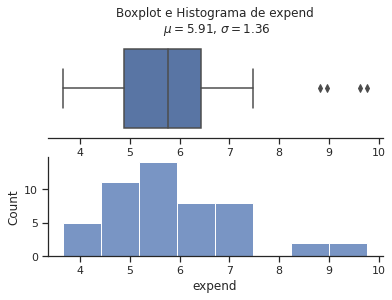

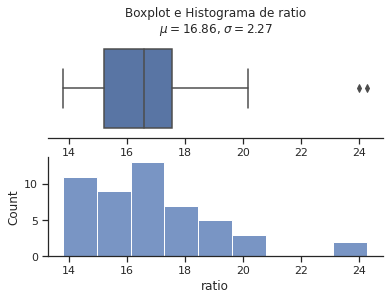

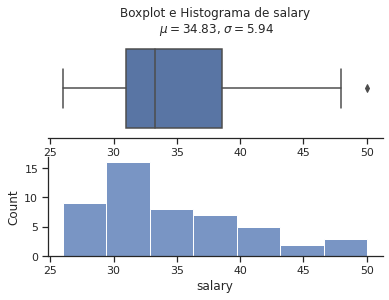

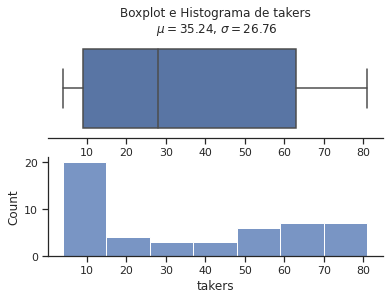

In [ ]:
for i in df.drop([ 'total'], axis = 1).columns:

  sns.set(style="ticks")

  x = df[i]
  coluna = i
  mu = round(x.mean(),2) # mean of distribution
  sigma = round(x.std(),2)  # standard deviation of distribution

  f, (ax_box, ax_hist) = plt.subplots(2)

  sns.boxplot(x=x, ax=ax_box)
  sns.histplot(x=x, ax=ax_hist)

  ax_box.set(yticks=[])
  sns.despine(ax=ax_hist)
  sns.despine(ax=ax_box, left=True)
  ax_box.set_title('Boxplot e Histograma de {}\n $\mu={}$, $\sigma={}$'.format(coluna, mu,sigma))


plt.show()

The dimensionality of our regressor variables does not seem to justify any normalization ot standardization. Now the correlation:

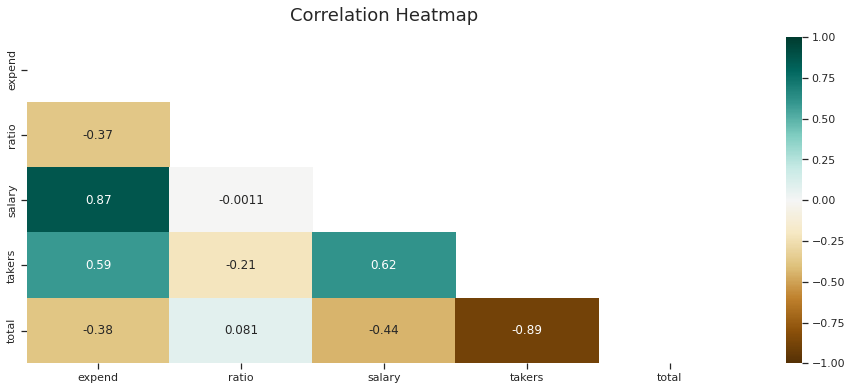

In [ ]:
#Correlation heatmap
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

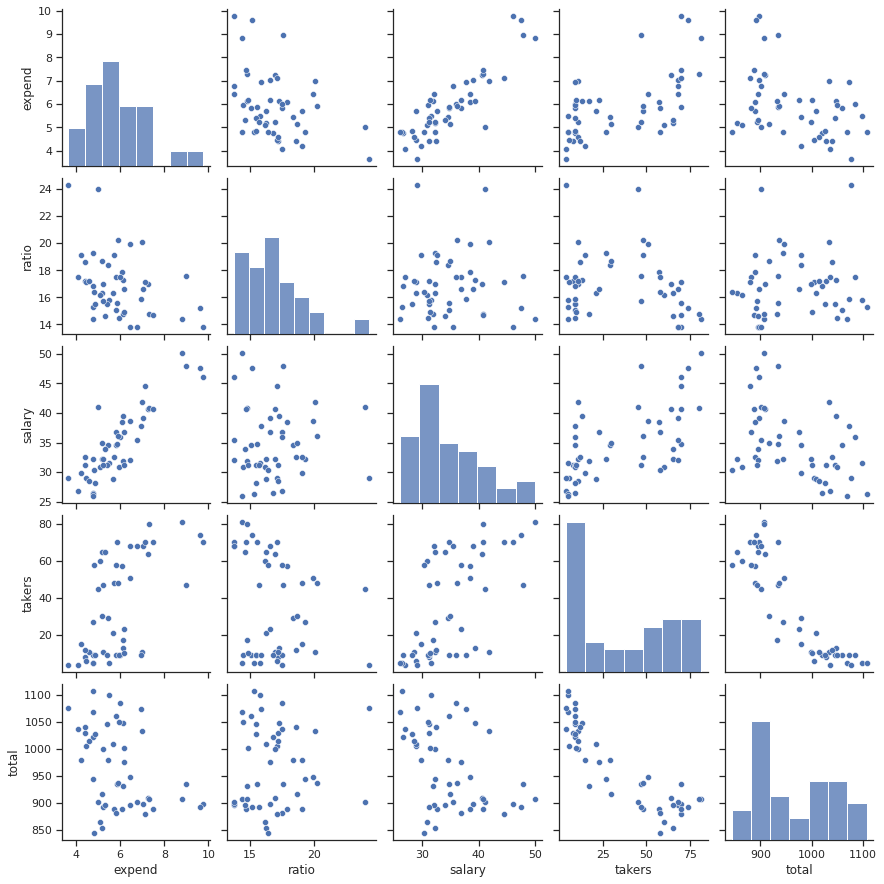

In [ ]:
#Scatterplots and histograms
sns.pairplot(df)

There is an expected positive correlation between **salary** and **expend**, but we will maintain both variables in our model, since we are trying to replicate Travis` analysis.

#Creating X and y axis

In [5]:
y = df['total']
X = df.drop(['total'], axis = 1)

#Modelling priors 

##Non informative prior

Travis` model uses noninformatives distributions (Normal to $\beta$ and InverseGamma to $\sigma^2$) and supposes the **Total** is also Normal.

$Total \sim N(\mu, \sigma^2)$

$\mu = \beta_0 + \beta_1 Expend + \beta_2 Ratio + \beta_3 Salary +\beta_4 Takers$

$\beta_i \sim Normal(0,10^{-6}) \text{ for i in [1,5]}$

$\sigma^2 \sim InverseGamma(1/2,10)$


ler dps -> https://discourse.pymc.io/t/nuts-sampler-effective-samples-is-smaller-than-200-for-some-parameters/5393

https://towardsdatascience.com/bayesian-linear-regression-in-python-via-pymc3-ab8c2c498211

In [6]:

# Formula for Bayesian Linear Regression (follows R formula syntax
formula = 'total ~ ' + ' + '.join(['%s' % variable for variable in df.columns[0:4]])
formula



'total ~ expend + ratio + salary + takers'

In [ ]:
from pymc3.distributions import posterior_predictive
import bambi as bmb
from bambi import Model, Family, Likelihood, priors

noninformative = bmb.priors.Prior('Normal', mu = 0, sigma = 10**(-3))
expend_p = bmb.priors.Prior('Normal', mu = 6, sigma = 10)
ratio_p = bmb.priors.Prior('Normal', mu = 17, sigma = 34)
salary_p = bmb.priors.Prior('Normal', mu = 34, sigma = 70)
takers_p = bmb.priors.Prior('Normal', mu = 35, sigma = 70)

s_invgamma = bmb.priors.Prior('InverseGamma', alpha = 1/2, beta = 10)


prior = {'expend': noninformative , 'ratio': noninformative,
       'salary': noninformative, 'takers': noninformative,
      'Intercept': noninformative, 'sigma' : s_invgamma }

with pm.Model():
  Model1 = bmb.Model(
      formula =formula, data=df, family = 'gaussian', priors = prior,
      dropna=True
  )
  results = Model1.fit(draws = 10000, tune = 1000, chains = 2, target_accept = 0.9)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [total_sigma, takers, salary, ratio, expend, Intercept]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 34 seconds.


###Visualize Priors Distributions

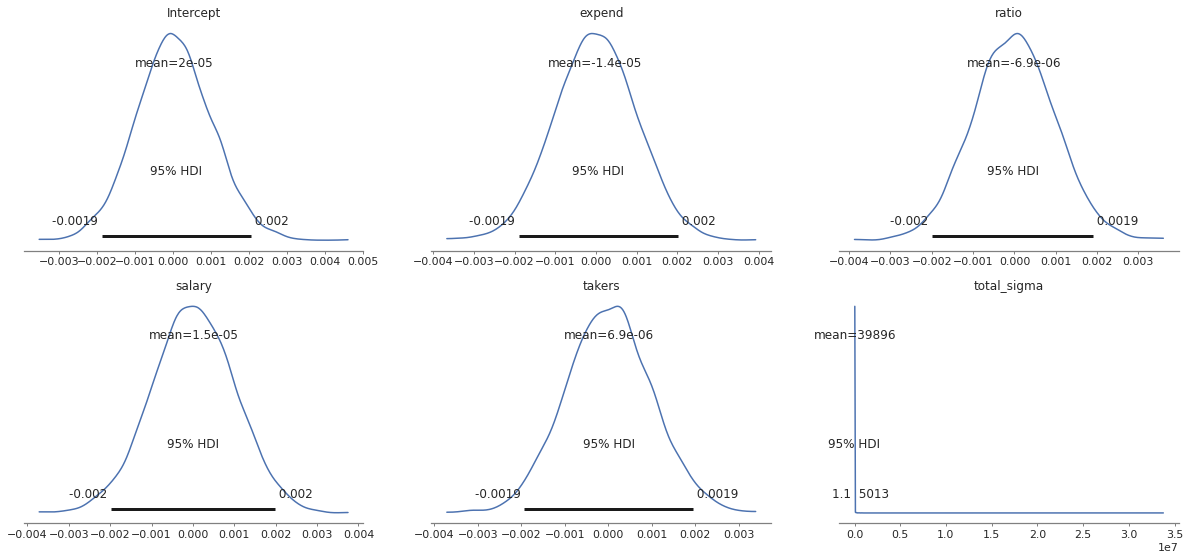

In [ ]:
Model1.plot_priors(hdi_prob = 0.95);

In [ ]:
Model1

Formula: total ~ expend + ratio + salary + takers
Family name: Gaussian
Link: identity
Observations: 50
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 0.001)
    expend ~ Normal(mu: 0, sigma: 0.001)
    ratio ~ Normal(mu: 0, sigma: 0.001)
    salary ~ Normal(mu: 0, sigma: 0.001)
    takers ~ Normal(mu: 0, sigma: 0.001)

  Auxiliary parameters
    sigma ~ InverseGamma(alpha: 0.5, beta: 10)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

###Trace plots for $\beta$ and $\sigma$

Before we take a look on the posteriors, it is important to analyze the convergence of the MCMC method.

We sampled our posterior from two chains, one is represented by the continuous blue line and the other by the trace blue line. On the graphs on the left we can see the distributions of our coefficients samples and, on the right the trace plots. We cant see any kind of crescent or decrescent pattern on the traces, indicating convergence of the chains. We cant also barely see the difference between the two lines(results of the chains), also indicating the convergence.

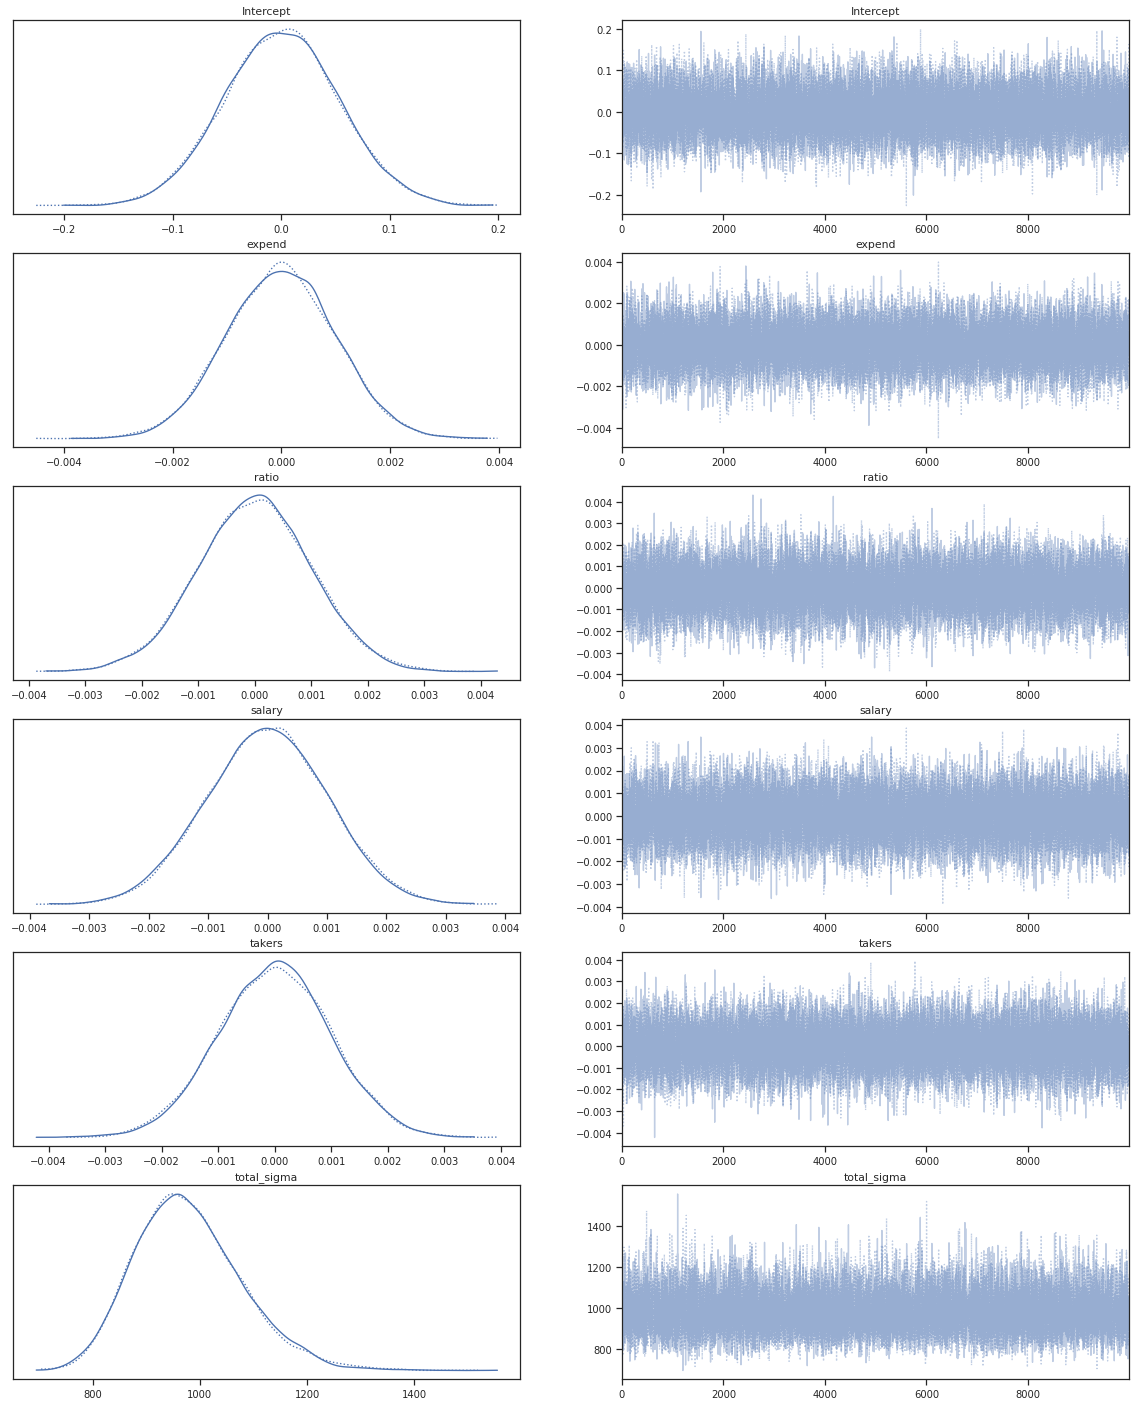

In [ ]:
pm.plot_trace(results, kind = 'trace', figsize = (20,25));

###95% Credible Intervals

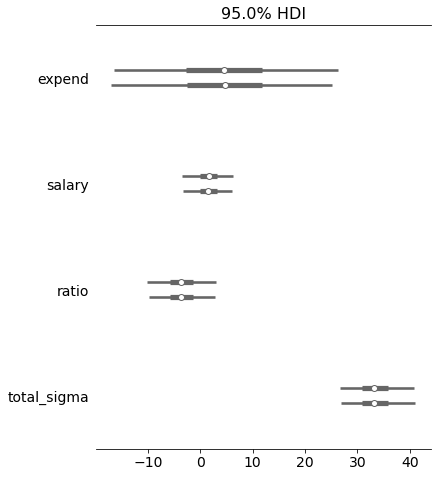

In [25]:
az.plot_forest(results, hdi_prob= 0.95, colors = ['#666666'],
               linewidth = 2.6, markersize = 8, var_names = ['expend', 'salary', 'ratio', 'total_sigma'] );

###Visualize Posteriors for $\beta$'s and $\sigma$

Since we have convergence of the sampled chains, we can assume that our model is good, right? Let`s see how our posteriors look like:

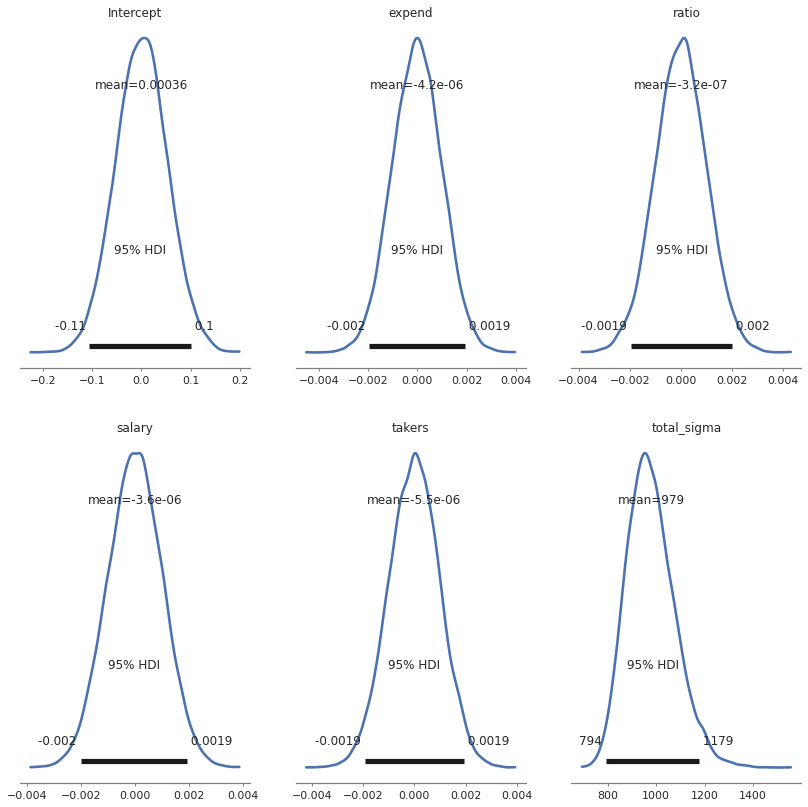

In [ ]:
az.plot_posterior(results, figsize = (14, 14), hdi_prob= 0.95, point_estimate= 'mean',
                  linewidth = 2.6);

In [ ]:
pm.summary(results, hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.000,0.053,-0.106,0.101,0.000,0.000,24489.0,15953.0,1.0
expend,-0.000,0.001,-0.002,0.002,0.000,0.000,24375.0,15345.0,1.0
ratio,-0.000,0.001,-0.002,0.002,0.000,0.000,24651.0,15795.0,1.0
salary,-0.000,0.001,-0.002,0.002,0.000,0.000,23681.0,15624.0,1.0
takers,-0.000,0.001,-0.002,0.002,0.000,0.000,25606.0,15186.0,1.0
total_sigma,979.024,99.630,793.914,1178.576,0.654,0.474,24570.0,14748.0,1.0


So it seems that we have a problem, since using the same model Travis got completely different results, as presented below:

<figure>
<img src = 'https://drive.google.com/uc?id=1SbMpXpTmysiTG6Ri0Ydy1SaVWHO6TRvt'
alt = ''>
</figure>

Even though we have the ideal value for r-hat (pointing that our Markov Chains have converged), our coefficients are too small in comparison with Travis' so maybe we just ended up with a different model, which, by itself, doesn't mean that it's a worse model. We can check this by looking at the posterior predictive.

###Posterior Predictive

Bambi uses a support library for plots called Arviz. This library stores the data of our regression into an InferenceData data structure, where we can always check our model's features. To do so, we just need to call the fitted object, in our case, *results*

In [ ]:
results

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Since we are interest in the posterior predictive, we will generate posterior predictive samples, for that we will use *.predict* on our InfereceData object. 

In [ ]:
posterior_predictive = Model1.predict(results, kind="pps", draws=500)
results

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> posterior_predictive

Now, we call Arviz to plot our predictive.

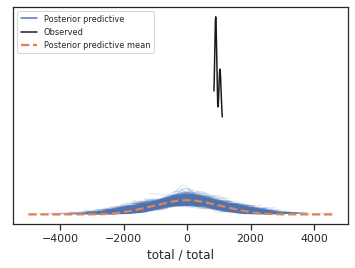

In [ ]:
az.plot_ppc(results)

As we can see our posterior are way far from our observed data which gives us the visual representation of how bad our model really is. But is this model worse than Travis'?

#Bambi`s Prios

If we don`t pass specify any priors, Bambi automatically assigns weakly informative priors scaling to them to the observed data.

In [8]:
from pymc3.distributions import posterior_predictive
import bambi as bmb
from bambi import Model, Family, Likelihood, priors

with pm.Model():
  Model1 = bmb.Model(
      formula =formula, data=df, family = 'gaussian',
      dropna=True
  )
  results = Model1.fit(draws = 10000, tune = 1000, chains = 2, target_accept = 0.9)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [total_sigma, takers, salary, ratio, expend, Intercept]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 57 seconds.


Let`s see the priors assigned

In [9]:
Model1

Formula: total ~ expend + ratio + salary + takers
Family name: Gaussian
Link: identity
Observations: 50
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 965.92, sigma: 1972.351)
    expend ~ Normal(mu: 0.0, sigma: 137.2545)
    ratio ~ Normal(mu: 0.0, sigma: 82.534)
    salary ~ Normal(mu: 0.0, sigma: 31.4834)
    takers ~ Normal(mu: 0.0, sigma: 6.9893)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 74.0686)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

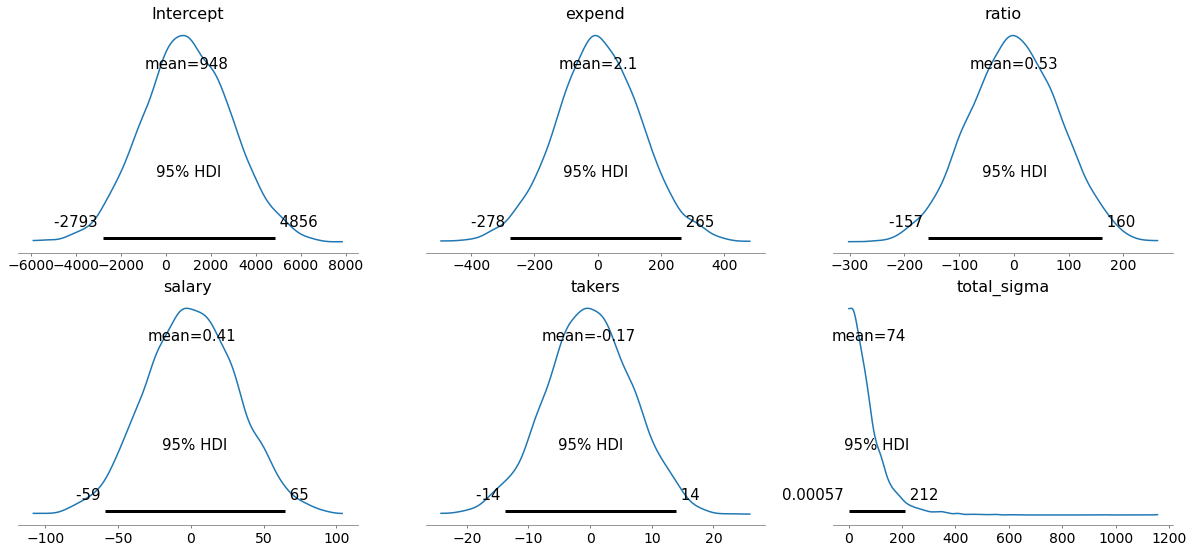

In [10]:
Model1.plot_priors(hdi_prob = 0.95);

Following the same steps as before, let`s take a look into our trace plot

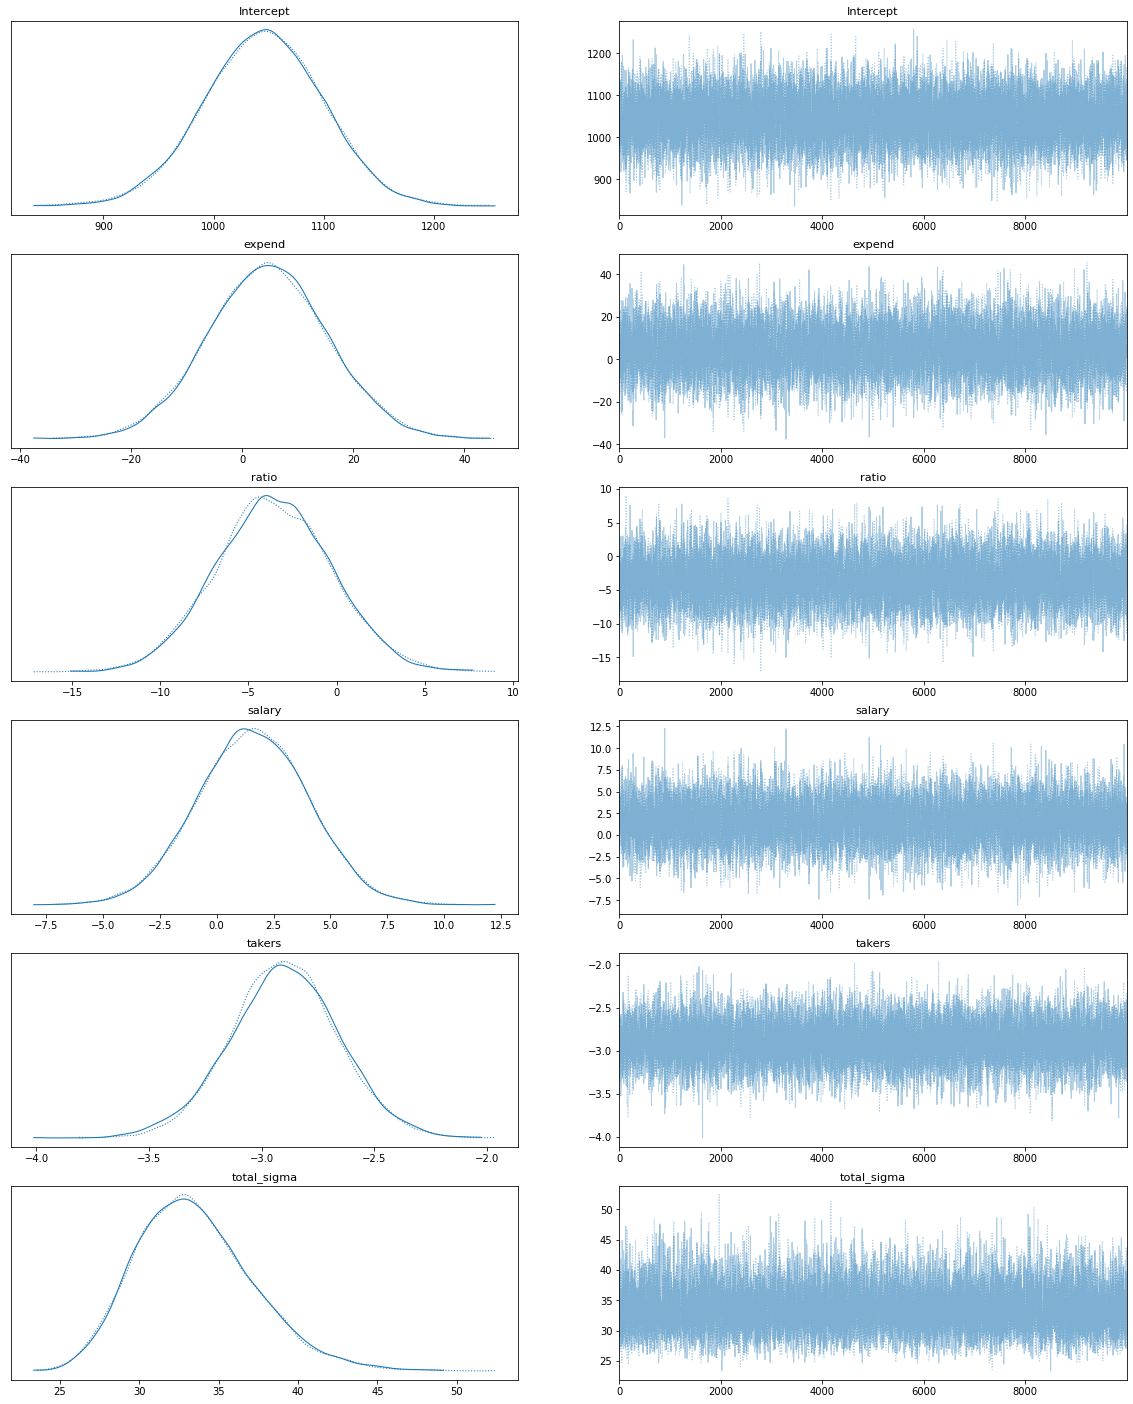

In [11]:
pm.plot_trace(results, kind = 'trace', figsize = (20,25));

Once again we have the convergence of the MCMC method. Now we look at our posterior and our posterior predictive.

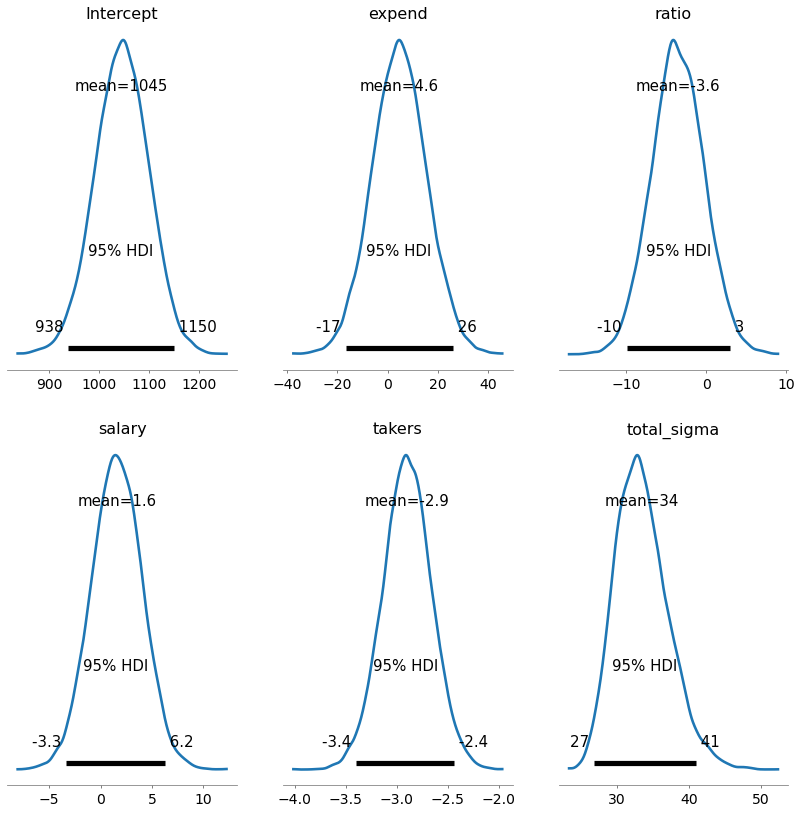

In [12]:
az.plot_posterior(results, figsize = (14, 14), hdi_prob= 0.95, point_estimate= 'mean',
                  linewidth = 2.6);

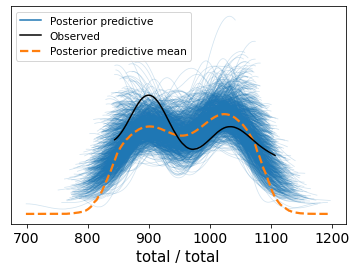

In [15]:
posterior_predictive = Model1.predict(results, kind="pps", draws=500)
az.plot_ppc(results)

Not only we were able to better predict the observed data, but we also reached a model that is closer than Travis`. Now we have the confirmation that our first model was, indeed, worse.

In [16]:
pm.summary(results, hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1045.222,54.292,937.860,1149.925,0.428,0.302,16131.0,15854.0,1.0
expend,4.616,10.897,-16.774,25.765,0.105,0.080,10774.0,11883.0,1.0
ratio,-3.560,3.308,-9.965,2.960,0.031,0.023,11388.0,12455.0,1.0
salary,1.598,2.459,-3.311,6.238,0.024,0.018,10467.0,11906.0,1.0
takers,-2.899,0.241,-3.394,-2.438,0.002,0.001,13674.0,11987.0,1.0
total_sigma,33.530,3.702,26.849,41.020,0.030,0.021,15597.0,12550.0,1.0


#Conclusions

We were able to reproduce Travis' experiment using Python's librarys for MCMC sampling and, while we couldn't exactly obtain the same model, our second attempt seems to predict the observed data very well. Reading rJAGS and Bambi documentation we see that the first uses Gibbs Sampling for the task, while the second automatic assigns NUTS (NO-U-Turn Sampler), a much more sophisticated algorithm, so that is probably why our noninformative prior ended up generating a bad model.


#Some others features

If we are interested in more specific predictive posteriors plots, we can use plot_lm passing our InfereceData in the idata parameter and the interest variables in y and x. Below we see how the **ratio** posterior predicts the **total.**

###Posteriori Predictive

/usr/local/lib/python3.7/dist-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64fbb2f390>]],
      dtype=object)

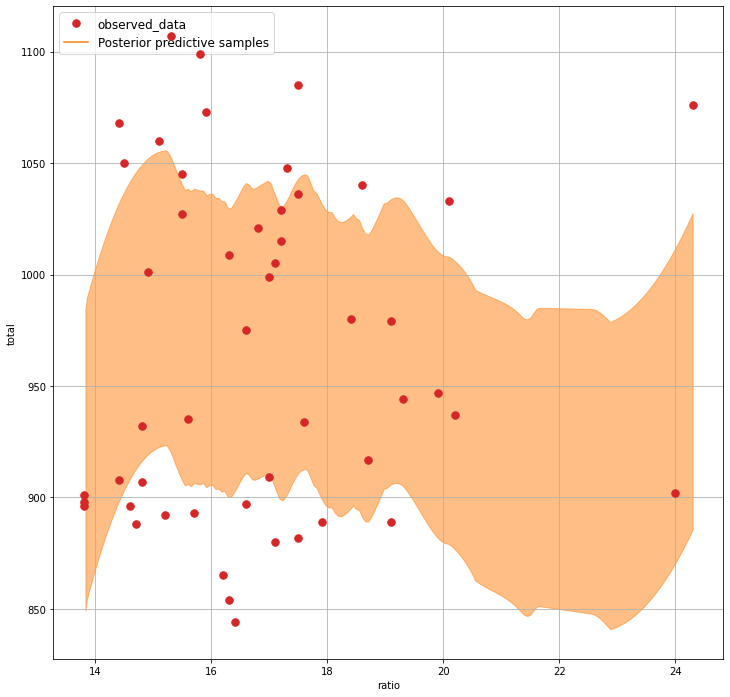

In [21]:
import xarray as xr

X = xr.DataArray(X) 
y = xr.DataArray(y) 
az.plot_lm(idata = results, y = 'total', x = df['ratio'], figsize = (12,12), textsize= 12, kind_pp = 'hdi'
           )

We can also change the uncertainty of the observed data, in the latest plot we use HDI, or high density intervals.

/usr/local/lib/python3.7/dist-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64fb969dd0>]],
      dtype=object)

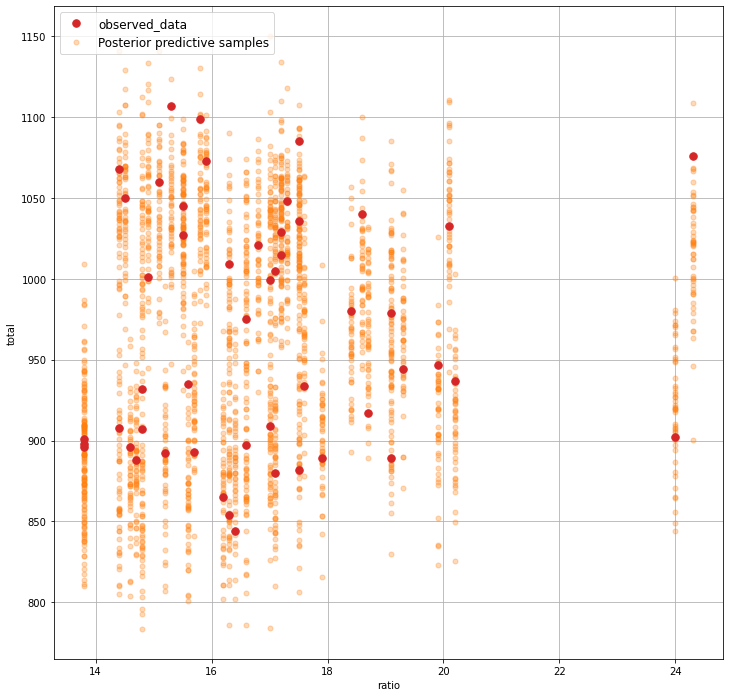

In [23]:
az.plot_lm(idata = results, y = 'total', x = df['ratio'], figsize = (12,12), textsize= 12
           )

There`s infinite option here so I strongly recommend check the documentation.

# Built in Diagnostics

We have seen that trace plots are a good way to determine the convergence of our sampling, but we can also see what happens to the autocorrelation in each chain sampled for the features. In this example, we sampled from two chains, and we see that the autocorrelation between samples diminished during the process. Our goal is to generate independent samples and, while this is not entirely possible because of the definition of Markov Chains, we want our samples to be as independent as they can be, thus we want to see the low autocorrelation. 

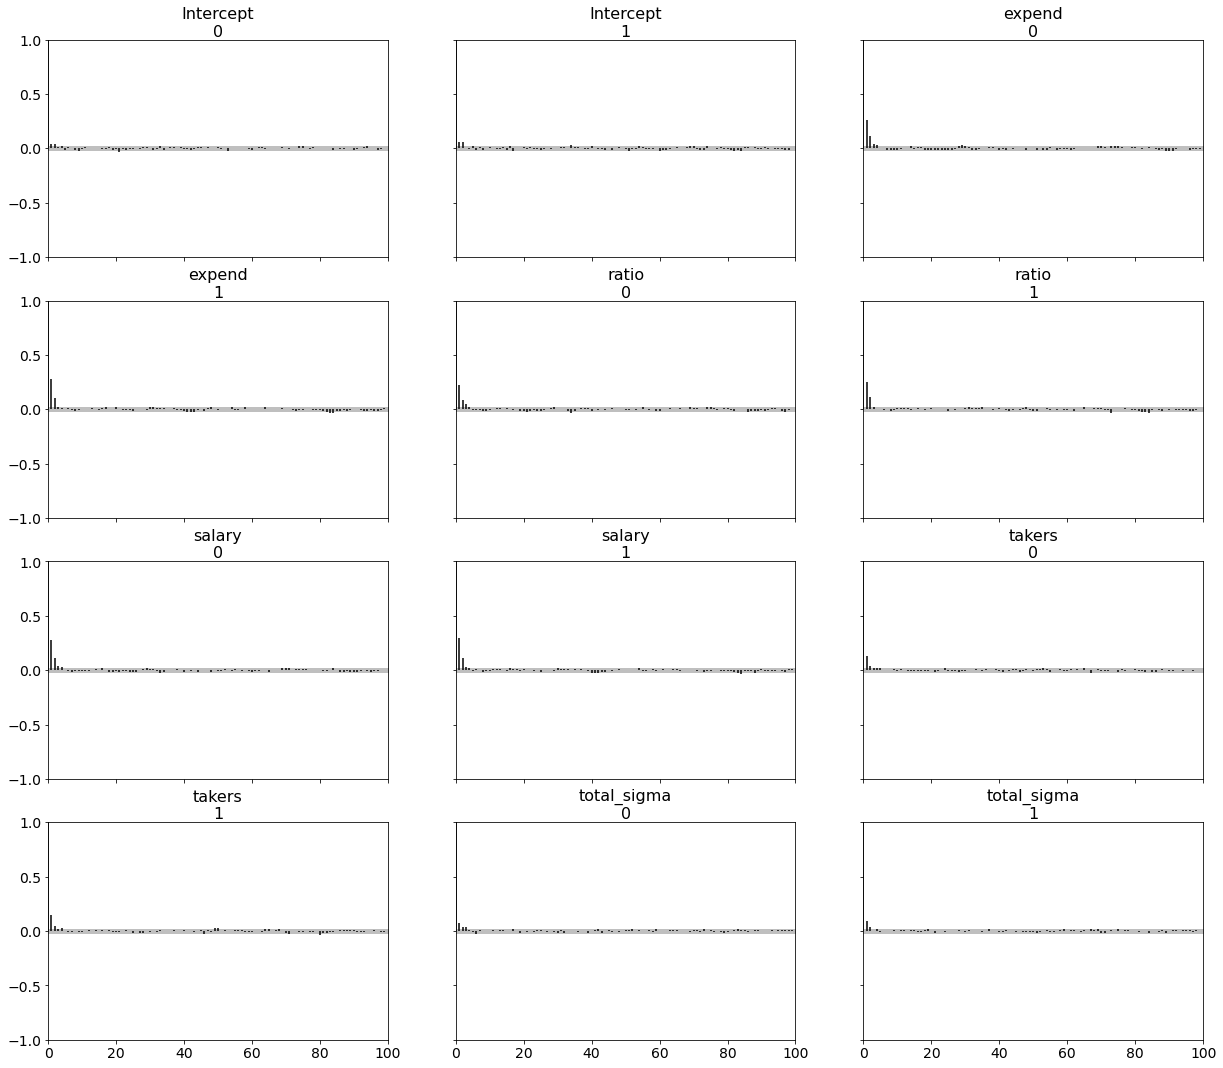

In [24]:
az.plot_autocorr(results);

#Bibliography
**Higher Spending Leads to Poorer Educatio**n -> https://medium.com/analytics-vidhya/higher-spending-leads-to-poorer-education-a-bayesian-statistics-project-using-rjags-b50b213c6961

**Sleep Analysis** -> https://towardsdatascience.com/markov-chain-monte-carlo-in-python-44f7e609be98\\

**Sleep Analysis Notebook** -> https://github.com/WillKoehrsen/ai-projects/blob/master/markov_chain_monte_carlo/markov_chain_monte_carlo.ipynb \\ 

**Bayesian Linear Regression in Pymc3** -> https://towardsdatascience.com/bayesian-linear-regression-in-python-via-pymc3-ab8c2c498211 \\ 

**Bayesian Linear Regression Project Notebook** -> https://github.com/WillKoehrsen/Data-Analysis/blob/master/bayesian_lr/Bayesian%20Linear%20Regression%20Project.ipynb

**How to use the Arviz plot_lm function?** -> https://utkarsh-maheshwari.medium.com/how-to-use-plot-lm-part-i-1f1cb099503e

**BAMBI - A Simple Interface for Fitting Bayesian Linear Models in Python** -> https://bambinos.github.io/bambi/main/index.html

**Arviz Documentation** -> https://arviz-devs.github.io/arviz/index.html

**PYMC3 Documentation** -> https://docs.pymc.io/en/v3/



